In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# scipy imports
import scipy.stats as stats

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# define cleaning functions
def clean_q_data_annual(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe, series, series
    '''
    # datetime operations
    q_df['dt'] = pd.to_datetime(q_df['dt_string'])
    q_df['year'] = q_df['dt'].dt.year
    q_df['month'] = q_df['dt'].dt.month
    q_df['day'] = q_df['dt'].dt.day

    # new datetime without time
    q_df['timestamp'] = pd.to_datetime(q_df[['year','month', 'day']], errors='coerce')

    # make series from groupby, this has timestamp as index
    daily_q = q_df.groupby(['timestamp'])['cfs'].mean()

    # make df from series
    daily_q_df = pd.DataFrame(daily_q)
    
    # annual peak Q
    annual_peak_q = q_df.groupby(q_df.year)['cfs'].max()

#     # cumulative Q
#     sum_q = q_df.groupby(q_df.year)['cfs'].cumsum()
#     sum_q_df = pd.DataFrame(q_df.year,sum_q).reset_index()
#     annual_sum_q = sum_q_df.groupby(sum_q_df.year)['cfs'].max()

    return(daily_q_df, annual_peak_q)

def clean_snow_data_annual(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    snow_df = dataframe
    # unit conversions to metric
    snow_df['swe_start_m'] = snow_df.swe_start_in * 0.0254
    snow_df['airtemp_max_C'] = 5/9*(snow_df.airtemp_max_F - 32)
    snow_df['airtemp_min_C'] = 5/9*(snow_df.airtemp_min_F - 32)
    snow_df['airtemp_mean_C'] = 5/9*(snow_df.airtemp_mean_F - 32)
    snow_df['precip_start_m'] = snow_df.precip_start_in * 0.0254
    snow_df['precip_incr_m'] = snow_df.precip_incr_in * 0.0254
    
    # drop standard unit columns
    snow_df.drop(['swe_start_in'], axis=1, inplace=True)
    snow_df.drop(['airtemp_max_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_min_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_mean_F'], axis=1, inplace=True)
    snow_df.drop(['precip_start_in'], axis=1, inplace=True)
    snow_df.drop(['precip_incr_in'], axis=1, inplace=True)
    
    # datetime operations
    snow_df['dt'] = pd.to_datetime(snow_df['dt_string'])
    snow_df['year'] = snow_df['dt'].dt.year
    snow_df['month'] = snow_df['dt'].dt.month
    
    # drop datetime string column
    snow_df.drop(['dt_string'], axis=1, inplace=True)

    # remove rows with swe=0
    snow_df.drop(snow_df[snow_df.swe_start_m == 0].index, inplace=True)

    #set snow df index to dt
    snow_df.set_index(snow_df.dt, inplace=True)
    
    # clean airtemp outliers
    snow_df = remove_outliers(snow_df)
    
    # annual peak swe
    annual_peak_swe = snow_df.groupby(snow_df.year)['swe_start_m'].max()
    
    # annual cumulative swe
    cumsum_swe = snow_df.groupby(snow_df['year'])['swe_start_m'].cumsum()
    
    # monthly cumulative swe
    swe_monthly = snow_df.groupby([snow_df['year'], snow_df['month']])['swe_start_m'].cumsum()
    
    return(snow_df, annual_peak_swe, cumsum_swe, swe_monthly)

def remove_outliers(df):
    ''' 
    input: dataframe of snotel data with columns re-named for degrees C
    output: dataframe
    '''
    # clear min airtemp outliers
    df.drop(df[df.airtemp_min_C > 18].index, inplace=True)
    df.drop(df[df.airtemp_min_C < -40].index, inplace=True)
    # clear max airtemp outliers
    df.drop(df[df.airtemp_max_C > 50].index, inplace=True)
    df.drop(df[df.airtemp_max_C < -45].index, inplace=True)
    return(df)

In [3]:
# load q data
q_df = pd.read_csv('q-data/gunnison_delta.csv',sep='\t',header=32) # read csv to dataframe
q_df.columns = ['USGS', 'id', 'dt_string', 'tz', 'cfs', 'junk'] # rename columns

daily_q_df, annual_peak_q = clean_q_data_annual(q_df)

# annual sum q
annual_cumsum_q = daily_q_df.groupby(daily_q_df.index.year)['cfs'].cumsum()
annual_sum_q = annual_cumsum_q.groupby(annual_cumsum_q.index.year).max()

In [4]:
#annual_sum_q

In [5]:
type(daily_q_df)

pandas.core.frame.DataFrame

In [6]:
# load snotel data
stationnames = ['680_park_cone','762_slumgullion','701_porphyry_creek','737_schofield_pass',
                '682_park_reservoir','669_north_lost_trail','1059_cochetopa_pass','618_mcclure_pass',
                '409_columbine_pass','675_overland_reservoir']

# make data column names
cols_data = []
for station in stationnames:
    sum_list = '{}_sumswe'.format(station[:3])
    cols_data.append(sum_list)
    peak_list = '{}_peakswe'.format(station[:3])
    cols_data.append(peak_list)
cols_data.append('peak_q')
cols_data.append('sum_q')

# merge snotel data with q data
data_lst = []
count = 0
peakswe_lst = []
sumswe_lst = []
monthly_lst = []
for stationname in stationnames:
    snow_df = pd.read_csv('snotel-data/snotel_{}.csv'.format(stationname),header=58) 
    snow_df.columns = ['dt_string', 'swe_start_in',
       'precip_start_in',
       'airtemp_max_F', 'airtemp_min_F',
       'airtemp_mean_F', 'precip_incr_in']
    
    snow_df['stn'] = stationname
    
    # import cleaned snow data
    snow_df, annual_peak_swe, cumsum_swe, swe_monthly = clean_snow_data_annual(snow_df)

    # merge datasets
    merged_df = pd.merge(snow_df, daily_q_df, how='left', left_index=True, right_index=True)

    data_lst.append(merged_df)
    peakswe_lst.append(annual_peak_swe)
    sumswe_lst.append(cumsum_swe)
    monthly_lst.append(swe_monthly)
    count += 1
print(count)

# contatenate data
data_df = pd.concat(data_lst, axis=0, ignore_index = True)

# set index as datetime
data_df.set_index('dt', inplace=True);





10


## cumulative/ aggregated data 

In [7]:
# # peak swe for each station
# peakswe_df = pd.concat(peakswe_lst,axis=1)
# peakswe_df.columns = stationnames

# # annual cumsum swe for each station
# cumsum_swe_df = pd.concat(sumswe_lst,axis=1)
# cumsum_swe_df.columns = stationnames

# # monthly cumsum swe for each station
# monthly_swe_df = pd.concat(monthly_lst,axis=1)
# monthly_swe_df.columns = stationnames
# monthly_swe_df['year'] = monthly_swe_df.index.year
# monthly_swe_df['month'] = monthly_swe_df.index.month

# # max sum swe by year for each station
# # cumsum_swe_df['year'] = cumsum_swe_df.index.year
# # sum_list = []
# # for name in stationnames:
# #     sum_list.append(cumsum_swe_df.groupby(cumsum_swe_df.year)[name].max())
# # sumswe_df = pd.concat(sum_list,axis=1)
# # sumswe_df.columns = stationnames

# #max sum swe by month, year for each station
# sum_list = []
# for name in stationnames:
#     sum_list.append(monthly_swe_df.groupby([monthly_swe_df.year, monthly_swe_df.month])[name].max())
# sumswe_df = pd.concat(sum_list,axis=1)
# sumswe_df.columns = stationnames

In [8]:
# eda of outliers removed
data_df.tail(20)

,stn,swe_start_m,airtemp_max_C,airtemp_min_C,airtemp_mean_C,precip_start_m,precip_incr_m,year,month,cfs
dt,,,,,,,,,,
2018-02-23,675_overland_reservoir,0.10414,-7.777778,-12.222222,-10.000000,0.18034,0.00762,2018,2,909.562500
2018-02-24,675_overland_reservoir,0.10922,-9.444444,-16.666667,-12.777778,0.18796,0.00000,2018,2,902.787234
2018-02-25,675_overland_reservoir,0.11176,-5.555556,-15.000000,-11.666667,0.18796,0.00000,2018,2,902.072917
2018-02-26,675_overland_reservoir,0.11176,-0.555556,-12.222222,-5.555556,0.18796,0.00254,2018,2,891.633333
2018-02-27,675_overland_reservoir,0.11176,1.111111,-9.444444,-3.888889,0.19050,0.00000,2018,2,895.447917
2018-02-28,675_overland_reservoir,0.11176,-0.555556,-12.777778,-7.222222,0.19050,0.00000,2018,2,906.739583
2018-03-01,675_overland_reservoir,0.11176,0.000000,-14.444444,-6.111111,0.19050,0.00254,2018,3,899.541667
2018-03-02,675_overland_reservoir,0.11176,5.000000,-2.777778,1.111111,0.19304,0.00254,2018,3,898.885417
2018-03-03,675_overland_reservoir,0.10922,6.111111,-0.555556,2.777778,0.19558,0.00000,2018,3,898.218750


In [9]:
data_all = pd.get_dummies(data_df)

In [10]:
data_all.tail(6)

,swe_start_m,airtemp_max_C,airtemp_min_C,airtemp_mean_C,precip_start_m,precip_incr_m,year,month,cfs,stn_1059_cochetopa_pass,stn_409_columbine_pass,stn_618_mcclure_pass,stn_669_north_lost_trail,stn_675_overland_reservoir,stn_680_park_cone,stn_682_park_reservoir,stn_701_porphyry_creek,stn_737_schofield_pass,stn_762_slumgullion
dt,,,,,,,,,,,,,,,,,,,
2018-03-09,0.10160,6.111111,-2.222222,1.111111,0.19558,0.00254,2018,3,899.479167,0,0,0,0,1,0,0,0,0,0
2018-03-10,0.10414,3.888889,-8.888889,-1.111111,0.19812,NaN,2018,3,902.010417,0,0,0,0,1,0,0,0,0,0
2018-03-11,0.10160,5.555556,-10.555556,-2.222222,0.19304,0.00000,2018,3,920.728261,0,0,0,0,1,0,0,0,0,0
2018-03-12,0.09906,7.222222,-6.111111,-0.555556,0.19304,0.00254,2018,3,919.541667,0,0,0,0,1,0,0,0,0,0
2018-03-13,0.10160,7.777778,-7.222222,-0.555556,0.19558,0.00000,2018,3,913.981481,0,0,0,0,1,0,0,0,0,0
2018-03-14,0.10160,NaN,NaN,NaN,0.19558,NaN,2018,3,NaN,0,0,0,0,1,0,0,0,0,0


In [11]:
# # merge q and swe data

# # merge sum and peak for each station
# data_x = pd.merge(sumswe_df,peakswe_df, how='left', left_index=True, right_index=True)
# data_xy = pd.concat((data_x,annual_peak_q,annual_sum_q),axis=1)

# # new columns
# cols_new = ['680_sumswe','762_sumswe','701_sumswe','737_sumswe','682_sumswe','669_sumswe','1059_sumswe',
#             '618_sumswe','409_sumswe','675_sumswe',
#             '680_peakswe','762_peakswe','701_peakswe','737_peakswe','682_peakswe','669_peakswe','1059_peakswe',
#             '618_peakswe','409_peakswe','675_peakswe','peak_q','sum_q']
# data_xy.columns = cols_new

# # clean data matrix
# data_xy.drop(data_xy[data_xy.index < 1985].index, inplace=True)

# # impute nans instead of remove
# data_xy_impute = data_xy.fillna(0) # only missing values for 1059

# # drop nans
# # data_xy_clean = data_xy.dropna()


In [12]:
#data_xy.tail(5)

In [13]:
data_all.index[0].year

1980

In [14]:
data_all.tail()

,swe_start_m,airtemp_max_C,airtemp_min_C,airtemp_mean_C,precip_start_m,precip_incr_m,year,month,cfs,stn_1059_cochetopa_pass,stn_409_columbine_pass,stn_618_mcclure_pass,stn_669_north_lost_trail,stn_675_overland_reservoir,stn_680_park_cone,stn_682_park_reservoir,stn_701_porphyry_creek,stn_737_schofield_pass,stn_762_slumgullion
dt,,,,,,,,,,,,,,,,,,,
2018-03-10,0.10414,3.888889,-8.888889,-1.111111,0.19812,NaN,2018,3,902.010417,0,0,0,0,1,0,0,0,0,0
2018-03-11,0.10160,5.555556,-10.555556,-2.222222,0.19304,0.00000,2018,3,920.728261,0,0,0,0,1,0,0,0,0,0
2018-03-12,0.09906,7.222222,-6.111111,-0.555556,0.19304,0.00254,2018,3,919.541667,0,0,0,0,1,0,0,0,0,0
2018-03-13,0.10160,7.777778,-7.222222,-0.555556,0.19558,0.00000,2018,3,913.981481,0,0,0,0,1,0,0,0,0,0
2018-03-14,0.10160,NaN,NaN,NaN,0.19558,NaN,2018,3,NaN,0,0,0,0,1,0,0,0,0,0


In [15]:
#np.shape(data_clean)

In [16]:
# quick clean
data_clean = data_all.dropna()

In [17]:
# prep data for model
model_df = data_clean
cols = model_df.columns

# split train and test data
split_year = 2017

train_df = model_df[model_df.index.year < split_year]
test_df = model_df[model_df.index.year >= split_year]

X_train = train_df.drop('cfs', axis=1)
y_train = train_df['cfs']

X_test = test_df.drop('cfs', axis=1)
y_test = test_df['cfs']



In [18]:
# make and fit model
alpha= 5
model = Ridge(alpha)
model.fit(X_train, y_train);
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)
# R2 score
score = model.score(X_test,y_test)
print('R2 = {0:.3f}'.format(score))

coefs = model.coef_
print(coefs)


R2 = 0.201
[-1.94151731e+03 -1.56072563e+00  3.34297626e+01 -1.76289681e+00
  5.88968618e+03 -1.15026868e+03 -3.04953613e+01  6.85264640e+01
  6.71488215e+02 -5.34073547e+02 -3.02998780e+02 -3.51305818e+02
  8.73307960e+01  5.87751078e+02 -4.19110934e+02  4.84555221e+02
 -6.96030022e+02  4.72393793e+02]


In [19]:
# coefficient matrix
# D = {}
# for idx, name in enumerate(stationnames):
#     D[name] = [[x for x in coefs[idx]], [y for y in coefs[idx+7]]]
# #print(D)

# import csv
# #write to file:
# with open('gunnison_coefs_peak_q.csv', 'w') as csv_file:
#     writer = csv.writer(csv_file)
#     for k, v in D.items():
#        writer.writerow([k,v])

sumswe_df.head()

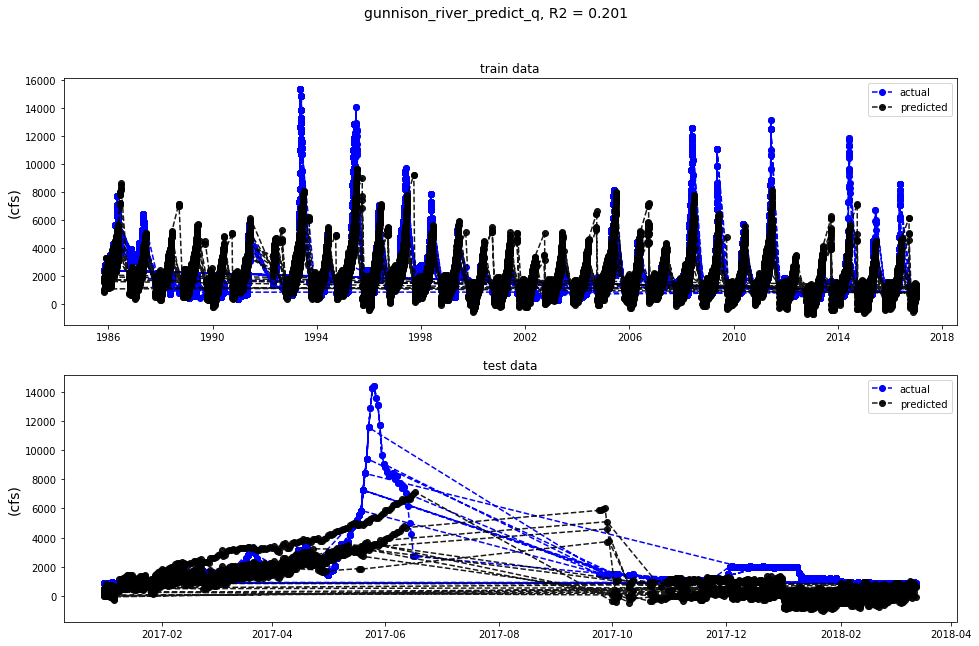

In [20]:
# plot predictions
# plots swe A, B
df = model_df # dataframe to plot from
#y # already made
#y_hat # already made
figname = 'gunnison_river_predict_q'

# plot
fig, ax = plt.subplots(2,1,figsize=(16,8));
ax[0].plot(y_train.index,y_train,'bo--')
ax[0].set_ylabel('(cfs)', fontsize=14);
#ax[0].set_xlabel('year', fontsize=14)
ax[0].plot(y_train.index,y_hat_train,'ko--',alpha=0.9)
ax[0].legend(['actual','predicted'])
ax[0].set_title('train data')

ax[1].plot(y_test.index,y_test,'bo--')
ax[1].set_ylabel('(cfs)', fontsize=14);
#ax[1].set_xlabel('year', fontsize=14)
ax[1].plot(y_test.index,y_hat_test,'ko--',alpha=0.9)
ax[1].legend(['actual','predicted'])
ax[1].set_title('test data')
plt.suptitle('{}, R2 = {}'.format(figname,str(round(score,3))),fontsize=14)

# arrs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
# for x, col in enumerate(cols[:-1]):
#     ax[arrs[x]].plot(df[col].values,y,'bo')
#     ax[arrs[x]].set_ylabel('q (cfs)');
#     ax[arrs[x]].set_xlabel(cols[x])
#     ax[arrs[x]].plot(df[col].values,y_hat,'ko')
#     ax[arrs[x]].legend(['actual','predicted'])
# plt.suptitle('{}, R2 = {}'.format(figname,str(round(score,3))),fontsize=14)

# save fig
fig.set_size_inches(16, 10)
plt.savefig('{}.png'.format(figname),format='png', dpi=300)

In [21]:
# # explore X,y
# fig, ax = plt.subplots(1,4,figsize=(16,8));
# ax[0].plot(X[cols[0]],y,'bo')
# #ax[0].set_ylabel('q (cfs)');
# #ax.set_xlabel(cols[x])
# ax[1].plot(X[cols[1]],y,'ko',alpha=0.1)
# #ax.legend(['actual','predicted'])